In [ ]:
#Note: Used references from Billy Fong (TA for DS210), as well as AWS references:
#https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_managed_spot_training.html

In [ ]:
#Note: only needed on initial install
#!pip install --upgrade sagemaker

## Setting up environment

In [2]:
#Importing key packages
import io
import os
import boto3
import sagemaker
import time
import botocore
from sagemaker import get_execution_role, image_uris, model_uris, script_uris, hyperparameters
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner
from time import gmtime, strftime
import matplotlib as plt
import numpy as np
import pandas as pd


In [3]:
#Setting up

role = sagemaker.get_execution_role()
boto_session = boto3.Session()
region = boto_session.region_name
sess = sagemaker.Session(boto_session=boto_session)

print("Role:", role)
print("Region:", region)
print("SageMaker Session Region:", sess.boto_region_name)

Role: arn:aws:iam::917456409349:role/Sagemaker_Execution_Role
Region: us-east-2
SageMaker Session Region: us-east-2


In [4]:
#Setting up Bucket Links/Info
bucket=sagemaker.Session().default_bucket()
s3_bucket_prefix= "sagemaker/adoption"
default_bucket_prefix = sagemaker.Session().default_bucket_prefix

if default_bucket_prefix:
    prefix = f"{default_bucket_prefix}/{s3_bucket_prefix}"
else:
    prefix=s3_bucket_prefix

In [5]:
prefix

'sagemaker/adoption'

In [6]:
#Set Container
container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")


## Ingesting Data and splitting/training/test

In [7]:
#Load Source file to do encoding and split train/test

bucket = "sagemaker-us-east-2-917456409349"
key = "sagemaker/adoption/harmonized_source_data/df_cat_dog_harmonized.csv" #Edit: Have to update this with new data source

# Initialize S3 client
s3_client = boto3.client("s3")

# Fetch the object from S3
obj = s3_client.get_object(Bucket=bucket, Key=key)

# Read into pandas DataFrame
df = pd.read_csv(io.BytesIO(obj['Body'].read()))

# Show the first few rows
df.head()

/tmp/ipykernel_565/1991622553.py:13: DtypeWarning: Columns (0,1,2,3,4,7,10,11,12,13,14,16,18,20,25,26,27,28,32,34,35,36,38,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.BytesIO(obj['Body'].read()))


,dob,returnedreason,intake_is_dead,return_date,intake_condition,was_outcome_alive,intake_date,animalage,animal_name,primary_color,...,stay_length_days,Num_returned,Is_returned,age_months,outcome_type_grouped,primary_color_final,outcome_type_final,intake_condition_final,intake_type_final,outcome_type_final_grouped
0,NaN,Owner requested Euthanasia,NaN,10/31/2024 12:00:00 AM,NaN,NaN,2009-11-28 00:00:00,15 years 1 month.,Jadzia,Tortoiseshell,...,2723.0,0,no,NaN,adoption,UNKNOWN,ADOPTION,NAN,OWNER SURRENDER,adopted
1,NaN,Stray,NaN,NaN,NaN,NaN,2009-12-08 00:00:00,14 years 0 months.,Gonzo,Tan,...,2694.0,0,no,NaN,adoption,TAN,ADOPTION,NAN,OWNER SURRENDER,adopted
2,NaN,Stray,NaN,2020-02-28 00:00:00,NaN,NaN,2012-08-10 00:00:00,12 years 1 month.,Maggie,Black and Tan,...,1709.0,0,no,NaN,adoption,BLACK TAN,ADOPTION,NAN,OWNER SURRENDER,adopted
3,NaN,Stray,NaN,2023-11-06 00:00:00,NaN,NaN,2020-02-28 00:00:00,12 years 1 month.,Maggie,Black and Tan,...,1.0,1,yes,NaN,other_outcome,BLACK TAN,RETURN TO OWNER,NAN,OWNER SURRENDER,adopted
4,NaN,Stray,NaN,NaN,NaN,NaN,2023-11-06 00:00:00,12 years 1 month.,Maggie,Black and Tan,...,41.0,2,yes,NaN,adoption,BLACK TAN,ADOPTION,NAN,OWNER SURRENDER,adopted


In [8]:
#Setting outcome_type_final_grouped to be first for Sagemaker Training

column = 'outcome_type_final_grouped'
cols = [column] + [col for col in df.columns if col != column]
df = df[cols]

#Check new order
df.head()


,outcome_type_final_grouped,dob,returnedreason,intake_is_dead,return_date,intake_condition,was_outcome_alive,intake_date,animalage,animal_name,...,has_name,stay_length_days,Num_returned,Is_returned,age_months,outcome_type_grouped,primary_color_final,outcome_type_final,intake_condition_final,intake_type_final
0,adopted,NaN,Owner requested Euthanasia,NaN,10/31/2024 12:00:00 AM,NaN,NaN,2009-11-28 00:00:00,15 years 1 month.,Jadzia,...,1,2723.0,0,no,NaN,adoption,UNKNOWN,ADOPTION,NAN,OWNER SURRENDER
1,adopted,NaN,Stray,NaN,NaN,NaN,NaN,2009-12-08 00:00:00,14 years 0 months.,Gonzo,...,1,2694.0,0,no,NaN,adoption,TAN,ADOPTION,NAN,OWNER SURRENDER
2,adopted,NaN,Stray,NaN,2020-02-28 00:00:00,NaN,NaN,2012-08-10 00:00:00,12 years 1 month.,Maggie,...,1,1709.0,0,no,NaN,adoption,BLACK TAN,ADOPTION,NAN,OWNER SURRENDER
3,adopted,NaN,Stray,NaN,2023-11-06 00:00:00,NaN,NaN,2020-02-28 00:00:00,12 years 1 month.,Maggie,...,1,1.0,1,yes,NaN,other_outcome,BLACK TAN,RETURN TO OWNER,NAN,OWNER SURRENDER
4,adopted,NaN,Stray,NaN,NaN,NaN,NaN,2023-11-06 00:00:00,12 years 1 month.,Maggie,...,1,41.0,2,yes,NaN,adoption,BLACK TAN,ADOPTION,NAN,OWNER SURRENDER


In [1]:
#Adding Custom Train/Test/Split
def assign_split(row):
    if row['shelter'] == "Bloomington":
        return "test"
    elif row['outcome_year'] < 2024:
        return "train"
    elif row['outcome_year'] in [2024, 2025] and row['shelter'] != "Bloomington":
        return "validate"
    else:
        return "exclude"  # fallback for any rows outside your logic

df['split'] = df.apply(assign_split, axis=1)


NameError: name 'df' is not defined

In [10]:
#See all columns
all_columns = df.columns.tolist()
print(all_columns)
print("Total columns:", len(all_columns))



['outcome_type_final_grouped', 'dob', 'returnedreason', 'intake_is_dead', 'return_date', 'intake_condition', 'was_outcome_alive', 'intake_date', 'animalage', 'animal_name', 'primary_color', 'primary_breed', 'deceasedreason', 'LastUpdate', 'Age', 'intake_type', 'outcome_year', 'animal_id', 'intake_reason', 'OutcomeCondition', 'istrial', 'Jurisdiction', 'istransfer', 'diedoffshelter', 'longitude', 'sex', 'deceased_date', 'identichipnumber', 'location', 'Crossing', 'outcome_date', 'isdoa', 'latitude', 'outcome_subtype', 'shelter', 'geopoint', 'sheltercode', 'secondary_color', 'puttosleep', 'intake_subtype', 'outcome_type', 'animal_type', 'outcome_is_dead', 'primary_breed_clean', 'secondary_breed', 'is_mix', 'intake_date_str', 'has_name', 'stay_length_days', 'Num_returned', 'Is_returned', 'age_months', 'outcome_type_grouped', 'primary_color_final', 'outcome_type_final', 'intake_condition_final', 'intake_type_final', 'split']
Total columns: 58


In [11]:
#Dropping unneeded columns
features_to_keep = ['outcome_type_final_grouped',
    'animal_type', 'primary_breed_clean', 'primary_color_final',
    'sex', 'intake_type_final', 'intake_subtype',
    'intake_condition_final', 'age_months', 'shelter', 'split'
]

# Trim the DataFrame to only those columns
df = df[features_to_keep].copy()

In [12]:
#See all columns
all_columns = df.columns.tolist()
print(all_columns)
print("Total columns:", len(all_columns))

['outcome_type_final_grouped', 'animal_type', 'primary_breed_clean', 'primary_color_final', 'sex', 'intake_type_final', 'intake_subtype', 'intake_condition_final', 'age_months', 'shelter', 'split']
Total columns: 11


In [13]:
#Pre-encoding Adoption
df['outcome_type_final_grouped'] = (df['outcome_type_final_grouped'] == 'adopted').astype(int)


In [53]:
#Encoding
from sklearn.preprocessing import LabelEncoder

# Copy original DataFrame
encoded_df = df.copy()

# List of categorical columns to encode (exclude numeric + non-feature cols)
categorical_cols = [
    col for col in encoded_df.columns
    if col not in ['age_months', 'shelter', 'split', 'outcome_type_final_grouped']
]

# Apply label encoding
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col].astype(str))
    le_dict[col] = le

# Fill missing age_months with median
median_age = encoded_df['age_months'].median()
encoded_df['age_months'] = encoded_df['age_months'].fillna(median_age)



In [54]:
# Saving Encoding
import pickle

with open("label_encoders.pkl", "wb") as f:
    pickle.dump(le_dict, f)




In [55]:
##EDIT: Need to do a standard format design CSV and ingest data into S3 bucket for inference

In [17]:
#See all columns
all_columns = encoded_df.columns.tolist()
print(all_columns)
print("Total columns:", len(all_columns))



['outcome_type_final_grouped', 'animal_type', 'primary_breed_clean', 'primary_color_final', 'sex', 'intake_type_final', 'intake_subtype', 'intake_condition_final', 'age_months', 'shelter', 'split']
Total columns: 11


In [18]:
encoded_df.head()

,outcome_type_final_grouped,animal_type,primary_breed_clean,primary_color_final,sex,intake_type_final,intake_subtype,intake_condition_final,age_months,shelter,split
0,1,0,181,108,1,7,45,6,48.0,Bloomington,test
1,1,1,229,86,3,7,45,6,48.0,Bloomington,test
2,1,1,414,8,1,7,45,6,48.0,Bloomington,test
3,1,1,414,8,1,7,45,6,48.0,Bloomington,test
4,1,1,414,8,1,7,45,6,48.0,Bloomington,test


In [19]:
len(encoded_df)

166028

In [20]:
# Splitting for training

df_train = encoded_df[encoded_df['split'] == 'train'].drop(columns=['split', 'shelter'])
df_test = encoded_df[encoded_df['split'] == 'test'].drop(columns=['split', 'shelter'])
df_validate = encoded_df[encoded_df['split'] == 'validate'].drop(columns=['split', 'shelter'])

# Save each to CSV (no index)
df_train.to_csv("train.csv", index=False)
df_test.to_csv("test.csv", index=False)
df_validate.to_csv("validate.csv", index=False)

# Output sizes
print("Train rows:", len(df_train))
print("Test rows:", len(df_test))
print("Validate rows:", len(df_validate))




Train rows: 103412
Test rows: 34532
Validate rows: 28083


In [21]:
df_train.head()


,outcome_type_final_grouped,animal_type,primary_breed_clean,primary_color_final,sex,intake_type_final,intake_subtype,intake_condition_final,age_months
34532,1,1,472,107,7,12,14,0,48.0
34533,0,1,119,86,2,7,14,4,108.0
34534,0,1,65,40,0,3,24,2,120.0
34536,1,1,119,2,6,12,24,5,144.0
34537,1,0,170,81,4,12,24,5,252.0


In [22]:
df_test.head()

,outcome_type_final_grouped,animal_type,primary_breed_clean,primary_color_final,sex,intake_type_final,intake_subtype,intake_condition_final,age_months
0,1,0,181,108,1,7,45,6,48.0
1,1,1,229,86,3,7,45,6,48.0
2,1,1,414,8,1,7,45,6,48.0
3,1,1,414,8,1,7,45,6,48.0
4,1,1,414,8,1,7,45,6,48.0


In [23]:
df_validate.head()

,outcome_type_final_grouped,animal_type,primary_breed_clean,primary_color_final,sex,intake_type_final,intake_subtype,intake_condition_final,age_months
34535,1,1,268,2,6,12,24,5,192.0
34635,0,1,119,20,4,3,25,2,228.0
34696,0,0,170,52,4,3,25,2,216.0
34697,1,1,319,107,4,4,45,5,228.0
34714,0,0,170,29,6,3,24,2,48.0


In [56]:
#Uploading to S3, without head or index

import io
import boto3

bucket_name = bucket
base_prefix = prefix
s3_client = boto3.client("s3")

# Reorder columns to ensure label is first
def reorder_columns(df, label_col):
    cols = [label_col] + [col for col in df.columns if col != label_col]
    return df[cols]

# Helper to upload a DataFrame as headerless CSV to S3
def upload_df_to_s3(df, path, label_col):
    df = reorder_columns(df, label_col)

    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, header=False)  # no header, no index
    s3_client.put_object(Bucket=bucket_name, Key=path, Body=csv_buffer.getvalue())
    print(f"Uploaded to s3://{bucket_name}/{path}")

# Upload each split
label_col = "outcome_type_final_grouped"

upload_df_to_s3(df_train, f"{base_prefix}/train/train_data.csv", label_col)
upload_df_to_s3(df_test, f"{base_prefix}/test/test_data.csv", label_col)
upload_df_to_s3(df_validate, f"{base_prefix}/val/validate_data.csv", label_col)



Uploaded to s3://sagemaker-us-east-2-917456409349/sagemaker/adoption/train/train_data.csv
Uploaded to s3://sagemaker-us-east-2-917456409349/sagemaker/adoption/test/test_data.csv
Uploaded to s3://sagemaker-us-east-2-917456409349/sagemaker/adoption/val/validate_data.csv


In [25]:
bucket

'sagemaker-us-east-2-917456409349'

In [26]:
prefix

'sagemaker/adoption'

In [27]:
key

'sagemaker/adoption/harmonized_source_data/df_cat_dog_harmonized.csv'

## Training Model Locally



 Training Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     70695
           1       0.71      0.76      0.74     32717

    accuracy                           0.83    103412
   macro avg       0.80      0.81      0.80    103412
weighted avg       0.83      0.83      0.83    103412



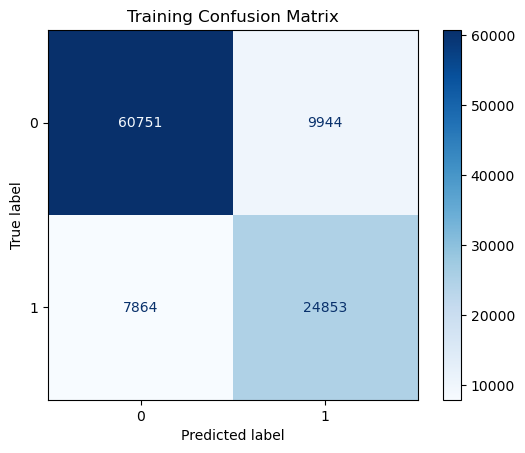


 Validation Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84     18322
           1       0.68      0.81      0.74      9761

    accuracy                           0.80     28083
   macro avg       0.78      0.80      0.79     28083
weighted avg       0.82      0.80      0.81     28083



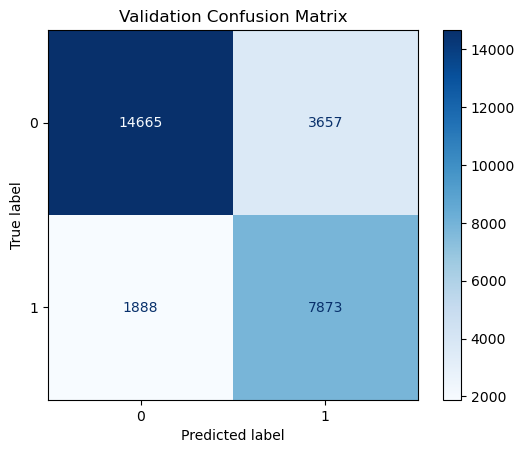


 Test Set Performance:
              precision    recall  f1-score   support

           0       0.37      0.84      0.51     12666
           1       0.64      0.16      0.26     21866

    accuracy                           0.41     34532
   macro avg       0.50      0.50      0.39     34532
weighted avg       0.54      0.41      0.35     34532



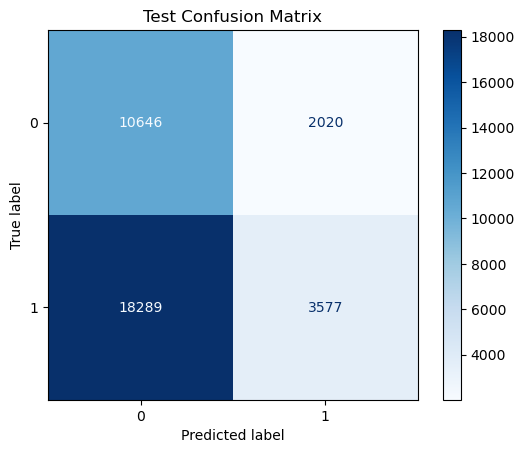

In [76]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Prepare datasets
X_train = df_train.drop(columns=['outcome_type_final_grouped'])
y_train = df_train['outcome_type_final_grouped']

X_val = df_validate.drop(columns=['outcome_type_final_grouped'])
y_val = df_validate['outcome_type_final_grouped']

X_test = df_test.drop(columns=['outcome_type_final_grouped'])
y_test = df_test['outcome_type_final_grouped']

# Define model
xgb_model = XGBClassifier(
    max_depth=5,
    learning_rate=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=50,
    #use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
def evaluate_performance(X, y_true, dataset_name):
    y_pred = xgb_model.predict(X)
    print(f"\n {dataset_name} Set Performance:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# Run evaluations
evaluate_performance(X_train, y_train, "Training")
evaluate_performance(X_val, y_val, "Validation")
evaluate_performance(X_test, y_test, "Test")




Fitting 3 folds for each of 486 candidates, totalling 1458 fits
 Best parameters found: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.6}

 Training Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.86      0.87     70695
           1       0.72      0.76      0.74     32717

    accuracy                           0.83    103412
   macro avg       0.80      0.81      0.80    103412
weighted avg       0.83      0.83      0.83    103412



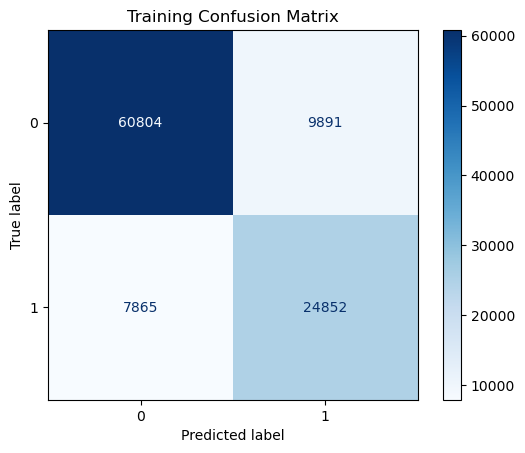


 Validation Set Performance:
              precision    recall  f1-score   support

           0       0.92      0.78      0.85     18322
           1       0.68      0.88      0.77      9761

    accuracy                           0.82     28083
   macro avg       0.80      0.83      0.81     28083
weighted avg       0.84      0.82      0.82     28083



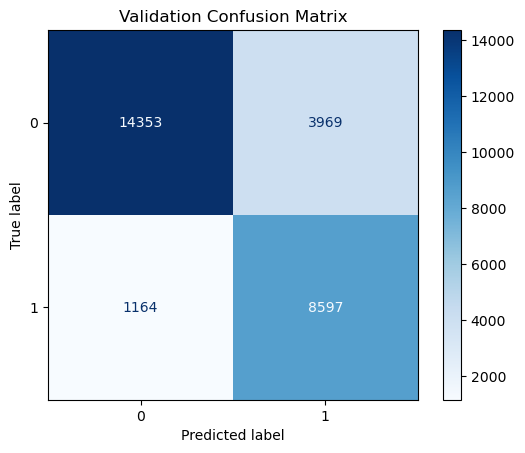


 Test Set Performance:
              precision    recall  f1-score   support

           0       0.37      0.97      0.54     12666
           1       0.75      0.05      0.10     21866

    accuracy                           0.39     34532
   macro avg       0.56      0.51      0.32     34532
weighted avg       0.61      0.39      0.26     34532



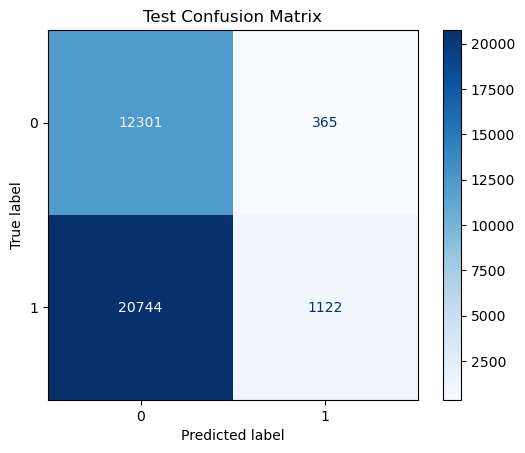

In [57]:
#Running AMT to see if can improve Test performance

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prepare data
X_train = df_train.drop(columns=['outcome_type_final_grouped'])
y_train = df_train['outcome_type_final_grouped']
X_val = df_validate.drop(columns=['outcome_type_final_grouped'])
y_val = df_validate['outcome_type_final_grouped']
X_test = df_test.drop(columns=['outcome_type_final_grouped'])
y_test = df_test['outcome_type_final_grouped']

# Combine train and val for tuning (cross-validation handles splits)
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'gamma': [0, 2, 4],
    'min_child_weight': [1, 4, 6],
    'subsample': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100],
}

# Initialize model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
   # use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',  #EDIT-do we want to optimize for something else?
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit search
grid_search.fit(X_trainval, y_trainval)
best_model = grid_search.best_estimator_
print(" Best parameters found:", grid_search.best_params_)

# Evaluate
def evaluate_performance(X, y_true, dataset_name):
    y_pred = best_model.predict(X)
    print(f"\n {dataset_name} Set Performance:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{dataset_name} Confusion Matrix")
    plt.show()

# Run evaluations
evaluate_performance(X_train, y_train, "Training")
evaluate_performance(X_val, y_val, "Validation")
evaluate_performance(X_test, y_test, "Test")


In [58]:
#Outputting Best Parameters, saving model 

best_params = grid_search.best_params_
print(best_params)

best_model.save_model("best_xgb_model_local.json") 



{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.6}


In [59]:
import pandas as pd

# Generate predictions
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Train
df_train_with_preds = df_train.copy()
df_train_with_preds.insert(0, "predicted_outcome", y_train_pred)
df_train_with_preds.to_csv("train_with_predictions.csv", index=False)

# Validation
df_val_with_preds = df_validate.copy()
df_val_with_preds.insert(0, "predicted_outcome", y_val_pred)
df_val_with_preds.to_csv("validate_with_predictions.csv", index=False)

# Test
df_test_with_preds = df_test.copy()
df_test_with_preds.insert(0, "predicted_outcome", y_test_pred)
df_test_with_preds.to_csv("test_with_predictions.csv", index=False)

print(" Saved all prediction files.")


 Saved all prediction files.


## Sagemaeker Model Parameter and Training

In [77]:
# Set Parameters for Binary Classification
# EDIT: Used same parameters as MengJiao
hyperparameters = {
    "max_depth": "5",
    "eta": "0.2",                   
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.7",
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "num_round": "50",      
    "verbosity": "2",
    "seed": "42",
    "scale_pos_weight": "2.16"  
}
# Set output
instance_type = "ml.m5.4xlarge"
output_path = "s3://{}/{}/output".format(bucket, prefix)
content_type = "csv"


#EDIT: Remember to redo with Hyperparameter Tuning

In [30]:
output_path
import boto3
import pandas as pd
import io

bucket = bucket
key = "sagemaker/adoption/train/train_data.csv"

# Load file from S3
s3 = boto3.client("s3")
response = s3.get_object(Bucket=bucket, Key=key)
body = response["Body"].read()

# Load into DataFrame 
df_preview = pd.read_csv(io.BytesIO(body), header=None)

# Show first few rows
print(df_preview.shape)
df_preview.head()


(103412, 9)


,0,1,2,3,4,5,6,7,8
0,1,1,472,107,7,12,14,0,48.0
1,0,1,119,86,2,7,14,4,108.0
2,0,1,65,40,0,3,24,2,120.0
3,1,1,119,2,6,12,24,5,144.0
4,1,0,170,81,4,12,24,5,252.0


In [31]:
#Training using predefined hyperparameters
#Edit: Used code from example XGBoost Model Abalone
#https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/xgboost_abalone/xgboost_managed_spot_training.html
#7/4/25

import time
from sagemaker.inputs import TrainingInput

job_name = "adoption-XGBoost" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print("Training job", job_name)

use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None
checkpoint_s3_uri = (
    "s3://{}/{}/checkpoints/{}".format(bucket, prefix, job_name) if use_spot_instances else None
)
print("Checkpoint path:", checkpoint_s3_uri)

estimator = sagemaker.estimator.Estimator(
    container,
    role,
    hyperparameters=hyperparameters,
    instance_count=1,
    instance_type=instance_type,
    volume_size=5,  # 5 GB
    output_path=output_path,
    sagemaker_session=sagemaker.Session(),
    use_spot_instances=use_spot_instances,#Edit
    max_run=max_run, #Edit
    max_wait=max_wait, #Edit
    checkpoint_s3_uri=checkpoint_s3_uri #Edit
)

train_input = TrainingInput(
    s3_data="s3://{}/{}/{}".format(bucket, prefix, "train"), content_type="text/csv"
)
estimator.fit({"train": train_input}, job_name=job_name)

INFO:sagemaker:Creating training-job with name: adoption-XGBoost2025-07-08-19-41-38


Training job adoption-XGBoost2025-07-08-19-41-38
Checkpoint path: s3://sagemaker-us-east-2-917456409349/sagemaker/adoption/checkpoints/adoption-XGBoost2025-07-08-19-41-38
2025-07-08 19:41:39 Starting - Starting the training job...
2025-07-08 19:42:12 Downloading - Downloading input data...
2025-07-08 19:42:27 Downloading - Downloading the training image......
2025-07-08 19:43:39 Training - Training image download completed. Training in progress.
2025-07-08 19:43:39 Uploading - Uploading generated training model.[2025-07-08 19:43:35.025 ip-10-0-240-214.us-east-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-07-08 19:43:35.048 ip-10-0-240-214.us-east-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-07-08:19:43:35:INFO] Imported framework sagemaker_xgboost_container.training
[2025-07-08:19:43:35:INFO] Failed to parse hyperparameter eval_metric value logloss to Json.
Returning the value itself
[2025-07-08:19:43:35:I

## Testing Sagemaker Endpoint Model - ONLY DO THIS TO TEST MODEL IS WORKING BEFORE TESTING ENDPOINT

In [60]:
import boto3

s3 = boto3.client('s3')
bucket = 'sagemaker-us-east-2-917456409349'
key = 'sagemaker/adoption/output/adoption-XGBoost2025-07-08-19-41-38/output/model.tar.gz'
local_path = 'model.tar.gz'

# Download model.tar.gz
s3.download_file(bucket, key, local_path)
print(" model.tar.gz downloaded locally.")

#Edit: Can likely install tar.gz from training done by MengJiao

 model.tar.gz downloaded locally.


In [61]:
import tarfile

# Extract model.tar.gz
with tarfile.open("model.tar.gz") as tar:
    tar.extractall("model_dir")

print(" Extracted model files:")
!ls model_dir


 Extracted model files:
xgboost-model


/tmp/ipykernel_565/3179333529.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("model_dir")


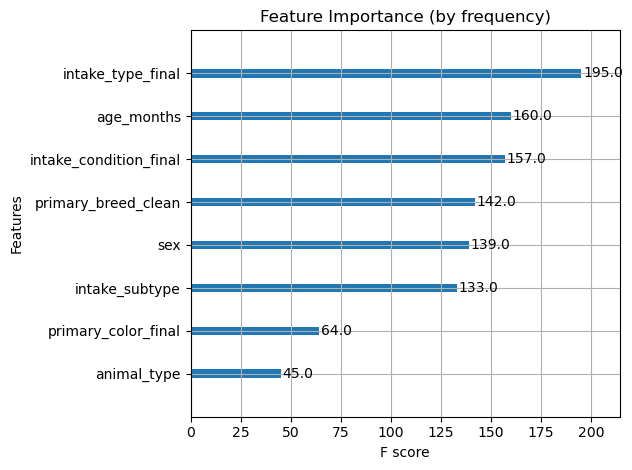

In [62]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Load trained model
booster = xgb.Booster()
booster.load_model("model_dir/xgboost-model")  # path from SageMaker tar.gz

# Manually assign feature names 
booster.feature_names = [
    "animal_type",
    "primary_breed_clean",
    "primary_color_final",
    "sex",
    "intake_type_final",
    "intake_subtype",
    "intake_condition_final",
    "age_months"
]

# Plot feature importance
xgb.plot_importance(booster, importance_type='weight', show_values=True)
plt.title("Feature Importance (by frequency)")
plt.tight_layout()
plt.show()




In [64]:
## Local Testing of tar.gz model

import xgboost as xgb
from sklearn.metrics import classification_report
import numpy as np

# Load trained model
booster = xgb.Booster()
booster.load_model("model_dir/xgboost-model")  

# Prepare datasets
X_train = df_train.drop(columns=["outcome_type_final_grouped"])
y_train = df_train["outcome_type_final_grouped"]

X_val = df_validate.drop(columns=["outcome_type_final_grouped"])
y_val = df_validate["outcome_type_final_grouped"]

X_test = df_test.drop(columns=["outcome_type_final_grouped"])
y_test = df_test["outcome_type_final_grouped"]

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train)
dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)

# Predict
y_train_pred = booster.predict(dtrain)
y_val_pred = booster.predict(dval)
y_test_pred = booster.predict(dtest)

# Round to binary labels
y_train_pred_labels = (y_train_pred >= 0.5).astype(int)
y_val_pred_labels = (y_val_pred >= 0.5).astype(int)
y_test_pred_labels = (y_test_pred >= 0.5).astype(int)

# Evaluate
print("Training Set Performance:")
print(classification_report(y_train, y_train_pred_labels, zero_division=0))

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred_labels, zero_division=0))

print("Test Set Performance:")
print(classification_report(y_test, y_test_pred_labels, zero_division=0))

# Prediction distributions
print(" Predicted labels distribution (val):", np.bincount(y_val_pred_labels))
print(" Predicted labels distribution (train):", np.bincount(y_train_pred_labels))
print(" Predicted labels distribution (test):", np.bincount(y_test_pred_labels))

# True label distributions
print(" True labels:")
print("Train:", np.bincount(y_train))
print("Val:  ", np.bincount(y_val))
print("Test: ", np.bincount(y_test))



Training Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     70695
           1       0.65      0.89      0.75     32717

    accuracy                           0.81    103412
   macro avg       0.79      0.83      0.80    103412
weighted avg       0.85      0.81      0.82    103412

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     18322
           1       0.64      0.94      0.76      9761

    accuracy                           0.79     28083
   macro avg       0.80      0.83      0.79     28083
weighted avg       0.85      0.79      0.80     28083

Test Set Performance:
              precision    recall  f1-score   support

           0       0.41      0.71      0.52     12666
           1       0.71      0.41      0.52     21866

    accuracy                           0.52     34532
   macro avg       0.56      0.56      0.52     3453

In [63]:
#OPTIONAL: Adding CSV with Predictions to S3 based on tar.gz downloaded model tested locally, may delete from final code #EDIT


import boto3
import io
import xgboost as xgb
import pandas as pd

# Prepare feature matrices
X_val = df_validate.drop(columns=["outcome_type_final_grouped"])
X_test = df_test.drop(columns=["outcome_type_final_grouped"])

dval = xgb.DMatrix(X_val)
dtest = xgb.DMatrix(X_test)

# Predict on Validation and Test
y_val_pred = booster.predict(dval)
y_val_pred_labels = (y_val_pred >= 0.5).astype(int)  # thresholding

y_test_pred = booster.predict(dtest)
y_test_pred_labels = (y_test_pred >= 0.5).astype(int)

# Append predictions to original DataFrames
df_val_with_preds = df_validate.copy()
df_val_with_preds.insert(0, "predicted_adoption", y_val_pred_labels)
df_val_with_preds.insert(1, "adoption_probability", y_val_pred.round(4))

df_test_with_preds = df_test.copy()
df_test_with_preds.insert(0, "predicted_adoption", y_test_pred_labels)
df_test_with_preds.insert(1, "adoption_probability", y_test_pred.round(4))

# Prep for uplaod to S3
def upload_df_to_s3(df, s3_key, bucket, s3_client):
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False)
    s3_client.put_object(Bucket=bucket, Key=s3_key, Body=csv_buffer.getvalue())
    print(f" Uploaded to s3://{bucket}/{s3_key}")

# Upload to S3
s3_client = boto3.client("s3")
bucket = "sagemaker-us-east-2-917456409349"

upload_df_to_s3(df_val_with_preds, "sagemaker/adoption/downloadable/val_with_predictions.csv", bucket, s3_client)
upload_df_to_s3(df_test_with_preds, "sagemaker/adoption/downloadable/test_with_predictions.csv", bucket, s3_client)





 Uploaded to s3://sagemaker-us-east-2-917456409349/sagemaker/adoption/downloadable/val_with_predictions.csv
 Uploaded to s3://sagemaker-us-east-2-917456409349/sagemaker/adoption/downloadable/test_with_predictions.csv


## Setting up Endpoint - ONLY DO WHEN SETTING UP ENDPOINT OTHERWISE SKIP OVER

In [40]:
#EDIT/NOTE: Do this after locally testing Sagemaker Model for effectiveness.

from sagemaker.serverless import ServerlessInferenceConfig
from sagemaker.model import Model

serverless_config = ServerlessInferenceConfig(
    memory_size_in_mb=6144,
    max_concurrency=3,
)

model = Model(
    image_uri=container,
    model_data=estimator.model_data,
    role=role,
    sagemaker_session=sagemaker.Session()
)

predictor = model.deploy(
    serverless_inference_config=serverless_config
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-07-08-19-58-01-461
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2025-07-08-19-58-02-136
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2025-07-08-19-58-02-136


---------------------------------!

## Endpoint Testing


In [44]:
#EDIT: Make sure to manually update endpoint name
endpoint_name = 'sagemaker-xgboost-2025-07-08-19-58-02-136'

In [46]:
# #Note: Files sourced in S3 Have no Headers but columns are: [
#     "outcome_type_final_grouped",  
#     "primary_breed_clean",
#     "primary_color_final",
#     "sex",
#     "intake_type_final",
#     "intake_subtype",
#     "intake_condition_final",
#     "age_months"
# ]

In [66]:
import boto3
import pandas as pd
import io
import numpy as np
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import classification_report

# configuring elements of s3
# bucket = "sagemaker-us-east-2-917456409349"
# prefix = "sagemaker/adoption"
# endpoint_name = 'sagemaker-xgboost-2025-07-08-19-58-02-136'
test_key = f"{prefix}/test/test_data.csv"
batch_size = 500 #Edit: Can adjust batch size to minimize calls latency

# initializing
s3_client = boto3.client("s3")
predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

# Load test data
obj = s3_client.get_object(Bucket=bucket, Key=test_key)
df = pd.read_csv(io.BytesIO(obj["Body"].read()), header=None)

# First column = label, rest = features
y_true = df.iloc[:, 0].values
X = df.iloc[:, 1:]

# Batch predicting
y_pred = []
for i in range(0, len(X), batch_size):
    batch = X.iloc[i:i + batch_size]
    payload = "\n".join([",".join(map(str, row)) for row in batch.values])
    response = predictor.predict(payload)
    scores = [p['score'] for p in response['predictions']]
    y_pred.extend([round(score) for score in scores])

# --- Evaluation ---
print(" test Set Performance:")
print(classification_report(y_true, y_pred))



 test Set Performance:
              precision    recall  f1-score   support

           0       0.41      0.71      0.52     12666
           1       0.71      0.41      0.52     21866

    accuracy                           0.52     34532
   macro avg       0.56      0.56      0.52     34532
weighted avg       0.60      0.52      0.52     34532



In [67]:
#Testing on Train Data

import boto3
import pandas as pd
import io
import numpy as np
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sklearn.metrics import classification_report

# configuring elements of s3
# bucket = "sagemaker-us-east-2-917456409349"
# prefix = "sagemaker/adoption"
# endpoint_name = 'sagemaker-xgboost-2025-07-08-19-58-02-136'
train_key = f"{prefix}/train/train_data.csv"
batch_size = 500 #Edit: Can adjust batch size to minimize calls latency

# initializing
s3_client = boto3.client("s3")
predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

# Load train data
obj = s3_client.get_object(Bucket=bucket, Key=train_key)
df = pd.read_csv(io.BytesIO(obj["Body"].read()), header=None)

# First column = label, rest = features
y_true = df.iloc[:, 0].values
X = df.iloc[:, 1:]

# Batch predicting
y_pred = []
for i in range(0, len(X), batch_size):
    batch = X.iloc[i:i + batch_size]
    payload = "\n".join([",".join(map(str, row)) for row in batch.values])
    response = predictor.predict(payload)
    scores = [p['score'] for p in response['predictions']]
    y_pred.extend([round(score) for score in scores])

# --- Evaluation ---
print(" train Set Performance:")
print(classification_report(y_true, y_pred))

 train Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.78      0.85     70695
           1       0.65      0.89      0.75     32717

    accuracy                           0.81    103412
   macro avg       0.79      0.83      0.80    103412
weighted avg       0.85      0.81      0.82    103412



## Endpoint Testing sending a Payload

In [68]:
import pandas as pd
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer


local_csv_path = "test.csv"
endpoint_name = "sagemaker-xgboost-2025-07-08-19-58-02-136"
batch_size = 500

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)


df_full = pd.read_csv(local_csv_path)
original_columns = df_full.columns.tolist()


# Drop first oclumn
X = df_full.drop(columns=[original_columns[0]])


preds = []
for i in range(0, len(X), batch_size):
    batch = X.iloc[i:i + batch_size]
    payload = "\n".join([",".join(map(str, row)) for row in batch.values])
    response = predictor.predict(payload)
    scores = [p["score"] for p in response["predictions"]]
    preds.extend([round(score) for score in scores])


df_with_preds = df_full.copy()
df_with_preds["predicted"] = preds


df_with_preds.to_csv("test_with_predictions_endpointpayload.csv", index=False)
print(" Saved test_with_predictions.csv with headers and predictions.")


 Saved test_with_predictions.csv with headers and predictions.


 Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.71      0.52     12666
           1       0.71      0.41      0.52     21866

    accuracy                           0.52     34532
   macro avg       0.56      0.56      0.52     34532
weighted avg       0.60      0.52      0.52     34532



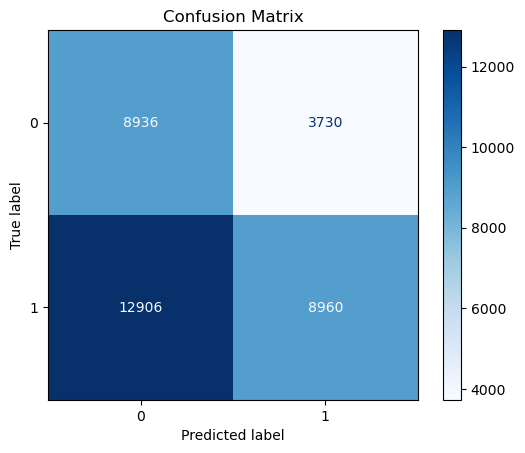

In [70]:
#Checking Endpoint Testing  via payload performance
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


df = pd.read_csv("test_with_predictions_endpointpayload.csv")

# True/pred labels
y_true = df.iloc[:, 0]  # Assuming first column is true label
y_pred = df["predicted"]

# Report out
print(" Classification Report:")
print(classification_report(y_true, y_pred))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


## Encoding Standardization for use on new csv.

In [72]:
import pandas as pd
import pickle

#EDIT: Will have to update this with new data structure from Mengjiao

# Load saved encoders
with open("label_encoders.pkl", "rb") as f:
    le_dict = pickle.load(f)

# load csv
df_test = pd.read_csv("test.csv")

# handle missing age months as above
median_age = df_test["age_months"].median()
df_test["age_months"] = df_test["age_months"].fillna(median_age)

#applying encodings
categorical_cols = [col for col in df_test.columns if col not in ['age_months', 'shelter', 'split', 'outcome_type_final_grouped']]

for col in categorical_cols:
    if col in le_dict:
        le = le_dict[col]
        known_classes = set(le.classes_)
        df_test[col] = df_test[col].astype(str).apply(lambda x: le.transform([x])[0] if x in known_classes else -1)


## EDIT: Set up CSV Lambda ingestion and encoding

In [ ]:
#coding needed

## EDIT: Need to set up Lambda Inference via Endpoint

In [73]:
#Coding needed

## EDIT: Need to draw out prime features from XGBOOST or other model

In [74]:
#Coding Needed

## EDIT: Athena or Streamlit takes scored CSV 

In [ ]:
#Coding Needed

## EDIT: Build Tableau Dashboard to Athena Tables

In [ ]:
#Coding Needed